In [1]:
# Cell 1: Setup
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
import torch
import itertools
from tqdm import tqdm

λ_grid = np.arange(500, 801, 1)
fluor_names = ['JF525','JF552','JF608','JFX673','JF722']
spectra_dir = Path("../data/spectra_npz")

# Cell 2: Load and interpolate spectra
def load_and_interpolate(fluor_names, spectra_dir, λ_grid):
    spectra = {}
    for name in fluor_names:
        path = spectra_dir / f"{name}.npz"
        data = np.load(path)
        wl = data["wavelengths_emission"]
        em = data["emission"] / data["emission"].max()
        interp = interp1d(wl, em, bounds_error=False, fill_value=0.0)
        spectra[name] = interp(λ_grid)
    return spectra

interpolated_emissions = load_and_interpolate(fluor_names, spectra_dir, λ_grid)
# Step 1: Load NADH spectrum
nadh_path = spectra_dir / "NADH.npz"
nadh_data = np.load(nadh_path)
nadh_wl = nadh_data["wavelengths_emission"]
nadh_em = nadh_data["emission"]
nadh_em /= nadh_em.max()  # normalize

# Interpolate onto λ_grid
from scipy.interpolate import interp1d
interp_nadh = interp1d(nadh_wl, nadh_em, bounds_error=False, fill_value=0)
nadh_em_interp = interp_nadh(λ_grid)

In [2]:
# Fixed σ and λ from your optimal configuration
optimal_sigmas = np.array([34.21, 22.63, 32.11, 36.32, 36.32])
optimal_centers = np.array([547.62, 576.38, 635.90, 684.48, 742.00])


In [3]:
def batch_simulator_fixed_filters(amplitude_batch, λ_grid, interpolated_emissions, nadh_em_interp,
                                  total_dye_photons=3e2, total_background_photons=3e1,
                                  edge_steepness=1.0, rng_seed=123):
    """
    Simulate photon counts for fixed microscope filter configuration.
    
    amplitude_batch: (B, 5) array of dye amplitudes
    Returns: (B, 5) tensor of channel photon counts
    """
    B = amplitude_batch.shape[0]
    C = 5
    x_batch = []

    rng = np.random.default_rng(seed=rng_seed)

    # Build filters once
    filters = np.stack([
        1 / (1 + np.exp(-(λ_grid - (c - w/2)) * edge_steepness)) *
        1 / (1 + np.exp((λ_grid - (c + w/2)) * edge_steepness))
        for c, w in zip(optimal_centers, optimal_sigmas)
    ])  # (5, λ)

    for amps in amplitude_batch:
        # Dye signals
        dye_signals = np.zeros((5, C))
        for i, (name, amp) in enumerate(zip(interpolated_emissions.keys(), amps)):
            spectrum = interpolated_emissions[name]
            dye_signals[i] = amp * np.sum(filters * spectrum, axis=1)

        signal_sum = dye_signals.sum()
        dye_photon_signal = dye_signals.sum(axis=0) / signal_sum * total_dye_photons if signal_sum > 0 else np.zeros(C)

        # NADH background
        bg_signal = np.sum(filters * nadh_em_interp, axis=1)
        bg_signal /= bg_signal.sum() if bg_signal.sum() > 0 else 1
        background_photon_signal = bg_signal * total_background_photons

        total_signal = dye_photon_signal + background_photon_signal
        noisy_counts = rng.poisson(total_signal).astype(np.float32)

        x_batch.append(noisy_counts)

    return torch.tensor(x_batch, dtype=torch.float32)


In [4]:
from sbi.inference import SNPE
from sbi.utils import BoxUniform, user_input_checks
import torch

# Define flat prior: amps only
# amp_bounds = (torch.zeros(5), torch.ones(5))
# prior = BoxUniform(*amp_bounds)
from torch.distributions import Dirichlet
prior = Dirichlet(concentration=torch.ones(5))
# Simulate training data
num_train = 10000
θ_train = prior.sample((num_train,))
x_train = batch_simulator_fixed_filters(θ_train.numpy(), λ_grid, interpolated_emissions, nadh_em_interp)

# Wrap simulator
def wrapped_simulator(theta):
    return batch_simulator_fixed_filters(
        theta.numpy(), λ_grid, interpolated_emissions, nadh_em_interp
    )

# 3. Prepare simulator and prior
simulator, prior = user_input_checks.prepare_for_sbi(wrapped_simulator, prior)



/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1153682/4098338778.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(x_batch, dtype=torch.float32)
/tmp/ipykernel_1153682/2525356774.py:22: DeprecationWarning: This method is deprecated as of sbi version v0.23.0. and will be removed in a         future release.Please use `process_prior` and `process_simulator` in the future.
  simulator, prior = user_input_checks.prepare_for_sbi(wrapped_simulator, prior)


In [ ]:
from sbi.inference import SNPE
from sbi.inference.potentials import posterior_estimator_based_potential
from sbi.utils.sbiutils import mcmc_transform
from sbi.utils import process_prior

# 1. Train as usual
inference = SNPE(prior=prior)
inference.append_simulations(θ_train, x_train)
density_estimator = inference.train()

# 2. Manually construct the posterior WITHOUT transform
# This avoids the incompatible mcmc_transform step

potential_fn, theta_transform = posterior_estimator_based_potential(
    posterior_estimator=density_estimator,
    prior=prior,
    x_o=None,
    enable_transform=False  # <-- key
)

# 3. Now build the posterior
posterior = inference.build_posterior(density_estimator, sample_with=)


 Neural network successfully converged after 113 epochs.

AssertionError: Mismatch between transformed and untransformed space. Note that you cannot
    use a transforms when using a MultipleIndependent prior with a Dirichlet prior.

In [13]:
from sbi.inference.posteriors.direct_posterior import DirectPosterior

# Assume: density_estimator is already trained and we already have `prior`
device = str(next(density_estimator.parameters()).device)

# Manual posterior definition: NO transform
posterior = DirectPosterior(
    posterior_estimator=density_estimator,
    prior=prior,
    device=device,
    enable_transform=False  # Disable transform
)


In [11]:
from numpy.random import default_rng
rng = default_rng(seed=42)
num_samples = 3000  # or however many you want
alpha = np.ones(5)  # uniform Dirichlet
amplitude_grid = rng.dirichlet(alpha, size=num_samples)
# Then simulate
x_fixed = batch_simulator_fixed_filters(amplitude_grid, λ_grid, interpolated_emissions, nadh_em_interp)


array([1., 1., 1., ..., 1., 1., 1.], shape=(3000,))

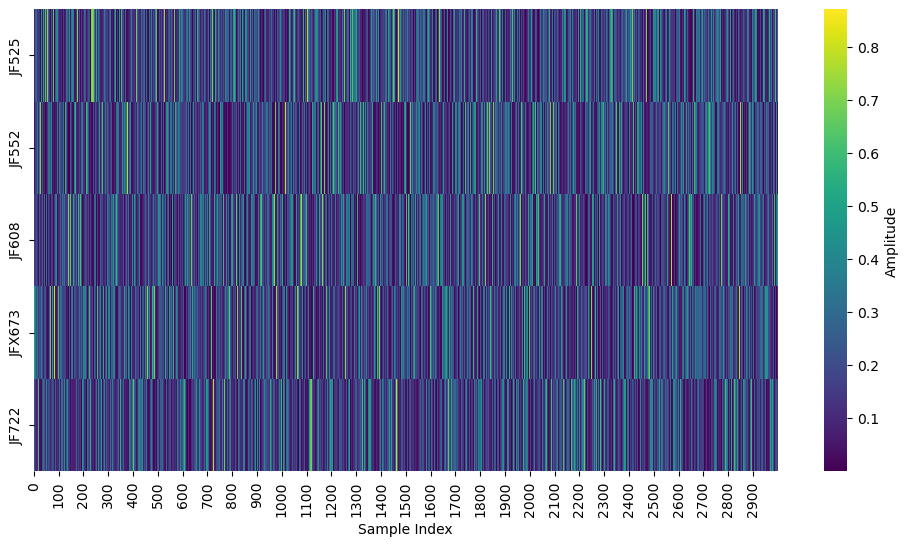

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume amplitude_grid is of shape (N, 5)
df = pd.DataFrame(amplitude_grid, columns=['JF525', 'JF552', 'JF608', 'JFX673', 'JF722'])

plt.figure(figsize=(12, 6))
sns.heatmap(df.T, cmap='viridis', cbar_kws={'label': 'Amplitude'}, xticklabels=100)
plt.xlabel("Sample Index")
np.sum(amplitude_grid, axis=1)  # Sum across all samples for each dye


In [14]:
posterior_means_fixed = []
r2_list = []

for i in tqdm(range(len(x_fixed))):
    x_i = x_fixed[i]
    amp_true = amplitude_grid[i]

    samples = posterior.sample((10,), x=x_i, show_progress_bars=False)
    amp_samples = samples.numpy()  # shape: (100, 5)

    amp_pred = amp_samples.mean(axis=0)
    posterior_means_fixed.append(amp_pred)

    # Centered R²
    amp_true_centered = amp_true - amp_true.mean()
    amp_samples_centered = amp_samples - amp_samples.mean(axis=1, keepdims=True)

    numerator = np.sum(amp_samples_centered * amp_true_centered, axis=1) ** 2
    denominator = np.sum(amp_samples_centered**2, axis=1) * np.sum(amp_true_centered**2)
    r2_vals = numerator / denominator
    r2_list.append(np.mean(r2_vals))

posterior_means_fixed = np.array(posterior_means_fixed)
r2_all = np.array(r2_list)


100%|██████████| 3000/3000 [04:34<00:00, 10.93it/s]


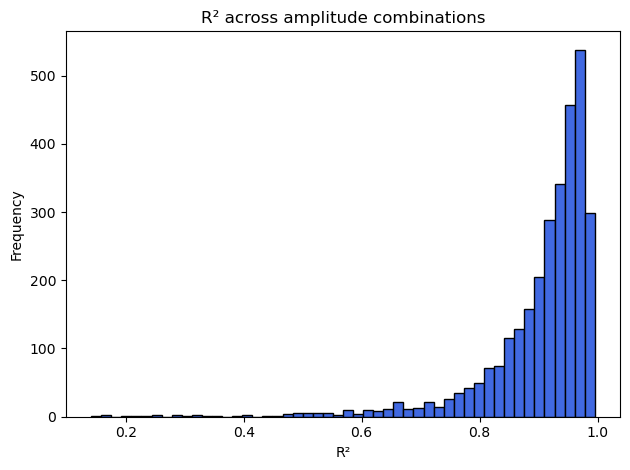

In [15]:
import matplotlib.pyplot as plt

plt.hist(r2_all, bins=50, color='royalblue', edgecolor='black')
plt.title("R² across amplitude combinations")
plt.xlabel("R²")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


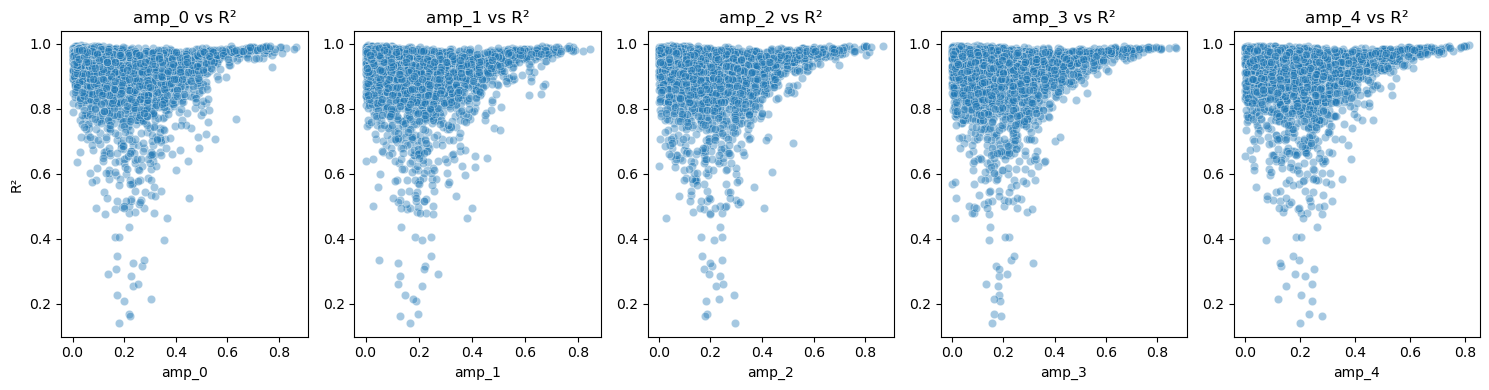

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `amplitude_grid` and `r2_all` are defined
# Create DataFrame from true amplitudes and their corresponding R²
df_amp_r2 = pd.DataFrame(amplitude_grid, columns=[f'amp_{i}' for i in range(5)])
df_amp_r2['r2'] = r2_all

# Plot each amplitude vs R²
plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    sns.scatterplot(x=df_amp_r2[f'amp_{i}'], y=df_amp_r2['r2'], alpha=0.4)
    plt.title(f"amp_{i} vs R²")
    plt.xlabel(f"amp_{i}")
    if i == 0:
        plt.ylabel("R²")
    else:
        plt.ylabel("")
plt.tight_layout()
plt.show()

# Summary statistics of bottom and top 5% R²
low_r2 = df_amp_r2[df_amp_r2["r2"] < np.percentile(r2_all, 5)]
high_r2 = df_amp_r2[df_amp_r2["r2"] > np.percentile(r2_all, 95)]




In [30]:
UMAP?

Init signature:
UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
Docstring:     
Uniform Manifold Appr

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


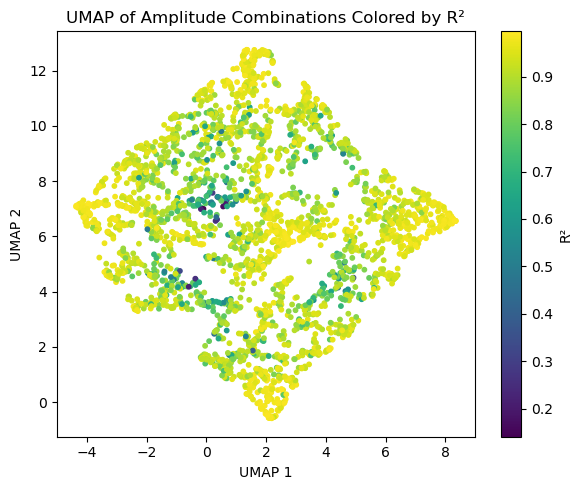

In [31]:
from umap import UMAP
import matplotlib.pyplot as plt

# Reduce to 2D
proj = UMAP(n_components=2, random_state=0).fit_transform(amplitude_grid)

# Plot with R² as color
plt.figure(figsize=(6, 5))
plt.scatter(proj[:, 0], proj[:, 1], c=r2_all, cmap='viridis', s=10)
plt.colorbar(label='R²')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP of Amplitude Combinations Colored by R²")
plt.tight_layout()
plt.show()


In [32]:
high_thresh = 0.9
low_thresh = 0.5

high_r2_mask = r2_all >= high_thresh
low_r2_mask = r2_all <= low_thresh

amp_high = amplitude_grid[high_r2_mask]
amp_low = amplitude_grid[low_r2_mask]

amp_high_mean = amp_high.mean(axis=0)
amp_low_mean = amp_low.mean(axis=0)

for i in range(5):
    print(f"Dye {i}: high R² mean amp = {amp_high_mean[i]:.3f}, low R² mean amp = {amp_low_mean[i]:.3f}")


Dye 0: high R² mean amp = 0.197, low R² mean amp = 0.220
Dye 1: high R² mean amp = 0.194, low R² mean amp = 0.196
Dye 2: high R² mean amp = 0.203, low R² mean amp = 0.212
Dye 3: high R² mean amp = 0.203, low R² mean amp = 0.177
Dye 4: high R² mean amp = 0.204, low R² mean amp = 0.196


In [33]:
import numpy as np
import pandas as pd

# Sort by R²
sorted_indices = np.argsort(r2_all)
top_n = 50
bottom_n = 50

best_combos = amplitude_grid[sorted_indices[-top_n:]]
worst_combos = amplitude_grid[sorted_indices[:bottom_n]]

# Create DataFrames for inspection
best_df = pd.DataFrame(best_combos, columns=[f'amp_{i}' for i in range(5)])
worst_df = pd.DataFrame(worst_combos, columns=[f'amp_{i}' for i in range(5)])


Best R² cluster centers (amplitude combos):
[[0.06761176 0.03359074 0.75551426 0.05030708 0.09297616]
 [0.057604   0.06551721 0.07387587 0.08709727 0.71590565]
 [0.73739791 0.04960172 0.06340476 0.08083745 0.06875816]
 [0.04231201 0.72224259 0.06357005 0.07873998 0.09313536]
 [0.07478011 0.04328808 0.07748955 0.74988292 0.05455935]]


Text(0.5, 1.0, 'Best R² Cluster Centers')

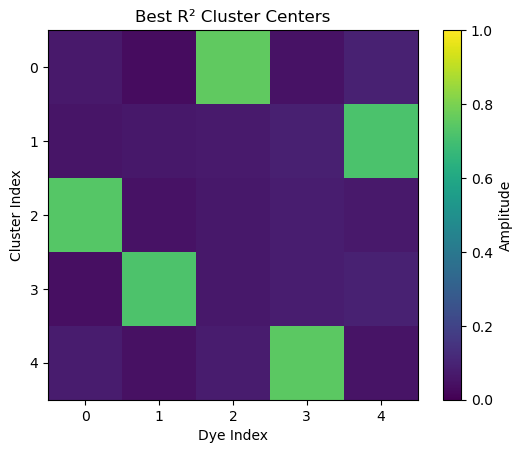

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(best_combos)
print("Best R² cluster centers (amplitude combos):")
print(kmeans.cluster_centers_)
plt.imshow(kmeans.cluster_centers_, vmin=0, vmax=1)
plt.colorbar(label='Amplitude')
plt.xlabel("Dye Index")
plt.ylabel("Cluster Index")
plt.title("Best R² Cluster Centers")

Best R² cluster centers (amplitude combos):
[[0.22792493 0.21936085 0.1669966  0.23014112 0.15557651]
 [0.2262534  0.26092044 0.1942188  0.07619562 0.24241175]
 [0.27932768 0.13524072 0.29479165 0.16885235 0.1217876 ]
 [0.19030039 0.15430966 0.23237087 0.18522989 0.23778919]
 [0.45203576 0.10463611 0.19282366 0.01574675 0.23475772]]


Text(0.5, 1.0, 'Worst R² Cluster Centers')

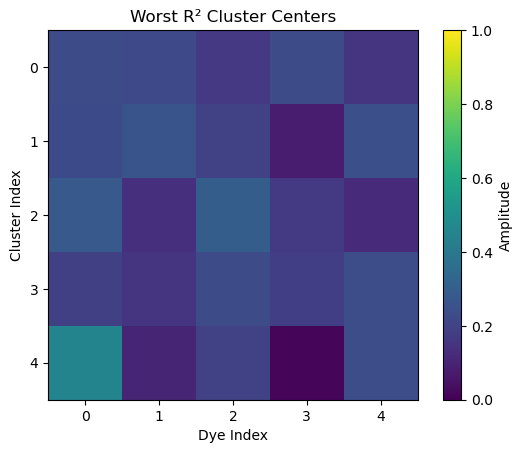

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(worst_combos)
print("Worst R² cluster centers (amplitude combos):")
print(kmeans.cluster_centers_)
plt.imshow(kmeans.cluster_centers_, vmin=0, vmax=1)
plt.colorbar(label='Amplitude')
plt.xlabel("Dye Index")
plt.ylabel("Cluster Index")
plt.title("Worst R² Cluster Centers")

In [ ]:
posterior_stds_per_cluster = []
posterior_means_per_cluster = []

for center in kmeans.cluster_centers_:
    x_i = torch.tensor(center, dtype=torch.float32)
    samples = posterior.sample((100,b), x=x_i, show_progress_bars=True).numpy()  # shape (500, 5)

    amp_std = samples.std(axis=0)   # per-dye STD
    amp_mean = samples.mean(axis=0)

    posterior_stds_per_cluster.append(amp_std)
    posterior_means_per_cluster.append(amp_mean)


KeyboardInterrupt: 

In [59]:
sample = posterior.sample((2,), x=x_i, show_progress_bars=True).numpy()  # shape (500, 5)


Drawing 2 posterior samples: 100%|██████████| 2/2 [04:52<00:00, 146.20s/it]


In [ ]:
posterior_stds_per_cluster = []
posterior_means_per_cluster = []

for center in kmeans.cluster_centers_:
    print(f"Cluster center: {center}")
    x_i = torch.tensor(center, dtype=torch.float32)
    samples = posterior.sample((20,), x=x_i, show_progress_bars=False).numpy()  # shape (500, 5)
async
    amp_std = samples.std(axis=0)   # per-dye STD
    amp_mean = samples.mean(axis=0)

    posterior_stds_per_cluster.append(amp_std)
    posterior_means_per_cluster.append(amp_mean)


Cluster center: [0.06761176 0.03359074 0.75551426 0.05030708 0.09297616]
Cluster center: [0.057604   0.06551721 0.07387587 0.08709727 0.71590565]
Cluster center: [0.73739791 0.04960172 0.06340476 0.08083745 0.06875816]


Drawing 100 posterior samples:   2%|▏         | 2/100 [4:11:31<205:24:36, 7545.68s/it]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
  File "/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/_weakrefset.py", line 97, in copy
    return self.__class__(self)
  File "/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/_weakrefset.py", line 51, in __init__
    self.update(data)
  File "/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/_weak

Cluster center: [0.04231201 0.72224259 0.06357005 0.07873998 0.09313536]
Cluster center: [0.07478011 0.04328808 0.07748955 0.74988292 0.05455935]


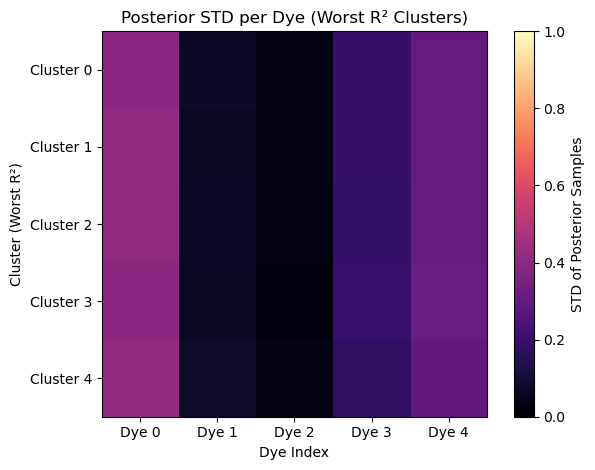

In [58]:
import matplotlib.pyplot as plt
import numpy as np

posterior_stds_per_cluster = np.array(posterior_stds_per_cluster)  # shape: (5 clusters, 5 dyes)

plt.imshow( np.array(posterior_means_per_cluster), vmin=0, vmax=1, cmap='magma')
plt.colorbar(label='STD of Posterior Samples')
plt.xlabel("Dye Index")
plt.ylabel("Cluster (Worst R²)")
plt.title("Posterior STD per Dye (Worst R² Clusters)")
plt.xticks(ticks=np.arange(5), labels=[f"Dye {i}" for i in range(5)])
plt.yticks(ticks=np.arange(5), labels=[f"Cluster {i}" for i in range(5)])
plt.tight_layout()
plt.show()
